# Synthetic Dataset Generator

**@author=Jairo da Silva Freitas Júnior**

This notebook is part of the essay "***Comparativo de técnicas de aprendizado sensível ao custo e reamostragem em conjuntos de dados desbalanceados***" (Comparison of cost sensitive learning and sampling on imbalanced datasets).


225 synthetic datasets with 10,000 examples and 2 gaussian variables each are created by varying the imbalance ratio ($l$), number of subconcepts ($d$, each subconcep is a cluster and emulate the existance of class subconcepts), subcocepts radius ($r$) and exclusion radius ($e$). This parameters are listed below:

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_blobs
from sklearn.neighbors import NearestNeighbors
import itertools as it
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns

#Configure plot
sns.set(rc={'figure.figsize':(10, 10)})
sns.set_style("white")

In [2]:
parameters = {
    'N': [10000],                               #Number of samples
    'v': [2],                                   #Number of gaussian variables
    'l': [(1,1), (1,2), (1,4), (1,9), (1,99)],  #Imbalance ratio
    'd': [2, 4, 8],                             #Number of subconcepts
    'r': [0.25, 0.5, 0.75],                     #Radius of subconcepts
    'e': [0, 1, 2]                    #Exclusion radius (distance in stds from subconcepts centers)
}
grid = {
    'majority': (0,0),
    '1': (-2, 2),
    '2': (2, -2),
    '3': (-2, -2),
    '4': (2, 2),
    '5': (-2, 0),
    '6': (2, 0),
    '7': (0,2),
    '8': (0, -2)
}
majority_bounds = (-3, 3)

Each class domain will be created around the seeds showed below. The percentage of borderline examples will be controlled via the radius of the majority class and minority class.

[]

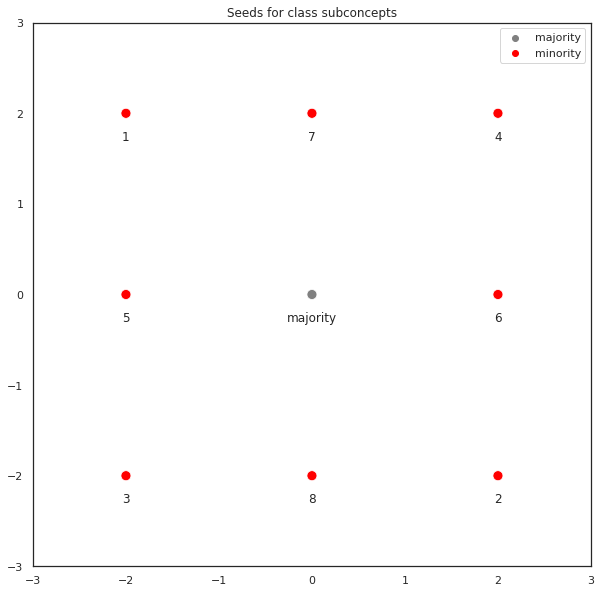

In [3]:
grid_keys = list(grid.keys())
grid_values = list(grid.values())
ax = sns.scatterplot(x=[x[0] for x in grid_values], 
                y=[x[1] for x in grid_values], 
                hue=['majority' if i==0 else 'minority' for i in range(len(grid))],
                s=100, palette=["grey", "red"],
                markers="s")

for i in range(len(grid)):
    ax.text(grid_values[i][0], grid_values[i][1]-0.3, grid_keys[i], horizontalalignment='center')

ax.set(xlim=(-3,3), ylim=(-3,3))
plt.title("Seeds for class subconcepts")
plt.plot()

In [4]:
def example_identification(X, Y, minority_class, k=5, radius=1):
    """
    This function classifies examples of a minority class as safe, borderline or noise. 
    Given Mn_i the number of minority neighbors of a minority example x_i, we classify x_i as:
    - safe, if Mn_i > k/2
    - borderline, if Mn > 0
    - noise, if none of x_i neighbors are of its class
    Please refer to the following article for more information about methodology. Also note
    that the default value of k is based on the same paper.
    Han H., Wang W., Mao B.: Borderline-SMOTE: A New Over-Sampling Method in Imbalanced Data 
    Sets Learning. In Proc. ICIC, Springer LNCS 3644, 2005, 878–887
    -----------------------------------------------------------------------------------------
    Input:
    X: matrix containing the dependent variables, one example per row
    Y: array containing the independent variable
    minoriry_class: value of Y that indicate the minority class
    k: number of neareast neighbors to evaluate in order to identify the type of each example
    -----------------------------------------------------------------------------------------
    Output:
    examples_type: array containing the type of each example
    """
    NON_MINORITY = 'majority'
    SAFE = 'safe'
    BORDERLINE = 'borderline'
    NOISE = 'noise'

    NUM_EXAMPLES = len(Y)

    #Find the k nearest examples for each example
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto', radius=radius).fit(X)
    _, indices = knn.kneighbors(X)

    #Count the number of minority neighbors for the examples of the minority class
    minority_neighbors_count = np.empty(NUM_EXAMPLES, dtype='int')
    for i in range(len(Y)):
        if Y[i] != minority_class:
            minority_neighbors_count[i] = -1
        else:
            c = 0 #Count using c to avoid list search every time
            for j in indices[i]:
                if Y[j] == minority_class:
                    c = c+1
            minority_neighbors_count[i] = c
    
    #Classify each example based on the counts of minority neighbors
    examples_type = np.empty(NUM_EXAMPLES, dtype='object')
    for i in range(len(minority_neighbors_count)):
        minority = minority_neighbors_count[i]
        if minority == -1:
            examples_type[i] = NON_MINORITY
        elif minority > k/2:
            examples_type[i] = SAFE
        elif minority > 1:
            examples_type[i] = BORDERLINE
        elif minority == 1:
            examples_type[i] = NOISE
        else:
            raise ("An invalid value was calculated for the number of minority neighbors of example "
                    +str(i))
    
    return examples_type

def examples_types_counter(examples_types):
    """
    This function returns statistics on the types of examples of a dataset.
    -----------------------------------------------------------------------------------------
    Input:
    examples_type: array with the type of each example
    -----------------------------------------------------------------------------------------
    Output:
    statistics: dictionary with the percentage of safe, borderline and noise examples of the
    minority class and the percentage of majority examples on the dataset.
    """
    statistics = {'samples': len(examples_types), 
            'majority_pct': (examples_types=='majority').sum()/len(examples_types),
            'minority_safe': (examples_types=='safe').sum()/(examples_types!='majority').sum(),
            'minority_borderline': (examples_types=='borderline').sum()/(examples_types!='majority').sum(),
            'minority_noise': (examples_types=='noise').sum()/(examples_types!='majority').sum()}
    return statistics

In [5]:
def create_random_uniform_samples(n_samples, n_features=2, class_label=0, min_val=0, max_val=1, seed=None):
    if seed!=None:
        np.random.seed(seed)
        
    scale_vals = max_val-min_val
    X = np.random.rand(n_samples, n_features)*scale_vals + min_val
    Y = np.ones(n_samples)*class_label
    return X, Y

def replace_majority_samples(X_majority_samples, centers, majority_bounds, min_distance):
    n_features = X_majority_samples.shape[1]
    replacement_seed = 0

    for i in range(len(X_majority_samples)):
        s = X_majority_samples[i]
        distances_s = [np.linalg.norm(s-c) for c in centers]
        if (any([x < min_distance for x in distances_s])):
            #Generate new safe majortity sample and replace current
            while(any([x < min_distance for x in distances_s])):
                replacement_seed += 1
                replacement = create_random_uniform_samples(1, n_features, 
                                                            0, 
                                                            majority_bounds[0],  majority_bounds[1], 
                                                            replacement_seed)[0][0]
                distances_s = [np.linalg.norm(replacement-c) for c in centers]
            X_majority_samples[i] = replacement
    return X_majority_samples


def make_binary_classification(number_samples, minority_class_centers, minority_class_radius,
                                majority_bounds, exclusion_radius, number_variables=2,
                                majority_class_weight=0.6, k=5):
    """
    This function create a dataset with ...
    -----------------------------------------------------------------------------------------
    Input:
    number_samples: Number of samples to be created
    minority_class_centers: coodinates of each minority class cluster center
    minority_class_radius: radius of each minority class cluster
    majority_bounds: tuple containing minimum and maximum values for the majority class
    exclusion_radius: distance (in stds) from minority class cluster center
    number_variables: Number of gaussian variables to create
    majority_class_weight: Percentage of samples that belong to the majority class
    k: number of neighbors to be considered for minority class example type identification
    """
    assert majority_class_weight>=0.5, "Majority class has less than 50 percent of samples"
    #Define number of samples for each class
    N_majority = int(majority_class_weight*number_samples)
    N_minority = number_samples - N_majority
    minority_cluster_std = minority_class_radius/2 #0.95 samples are within 2stds

    #Create samples
    X_minority_samples, Y_minority_samples = make_blobs(n_samples=N_minority, 
                                                        n_features=number_variables, 
                                                        random_state=1,
                                                        centers=minority_class_centers, 
                                                        cluster_std=minority_cluster_std)
    X_majority_samples, Y_majority_samples = create_random_uniform_samples(N_majority, 
                                                                            number_variables, 
                                                                            0, 
                                                                            majority_bounds[0], 
                                                                            majority_bounds[1], 
                                                                            1)
    X_majority_samples = replace_majority_samples(X_majority_samples, minority_class_centers, 
                                                  majority_bounds, exclusion_radius*minority_cluster_std)

    X_samples = np.concatenate((X_majority_samples, X_minority_samples))
    Y_samples = np.concatenate([np.zeros(len(Y_majority_samples)), np.ones(len(Y_minority_samples))])

    #Calculate sample statistics
    sample_types = example_identification(X_samples, Y_samples, 1, k=k)
    sample_statistics = examples_types_counter(sample_types)

    return (X_samples, Y_samples, sample_types, sample_statistics)

## Creation of datasets from parameters

In [10]:
dataset_params = it.product(*(parameters[param] for param in parameters.keys()))
datasets = []
for (N, v, l, d, r, e) in dataset_params:
    X_samples, Y_samples, sample_types, sample_statistics = make_binary_classification(number_samples=N, 
                                                                                       minority_class_centers=grid_values[1:d+1],
                                                                                       minority_class_radius=r,
                                                                                       majority_bounds=majority_bounds,
                                                                                       exclusion_radius=e, 
                                                                                       number_variables=v, 
                                                                                       majority_class_weight=l[1]/sum(l), 
                                                                                       k=5)
    dataset = np.concatenate((X_samples, [[y] for y in Y_samples]), axis=1)
    datasets.append(dataset)
    df = pd.DataFrame(dataset, columns=['x1', 'x2', 'y'])
    df['type'] = sample_types
    f_name = "N{n}_v{v}_l{l}_d{d}_r{r}_e{e}.csv".format(n=N, v=v, l=l[1], d=d, r=int(r*100), e=int(e*100))
    df.to_csv("../output/"+f_name, index=False)

## Figure of datasets varying _e_

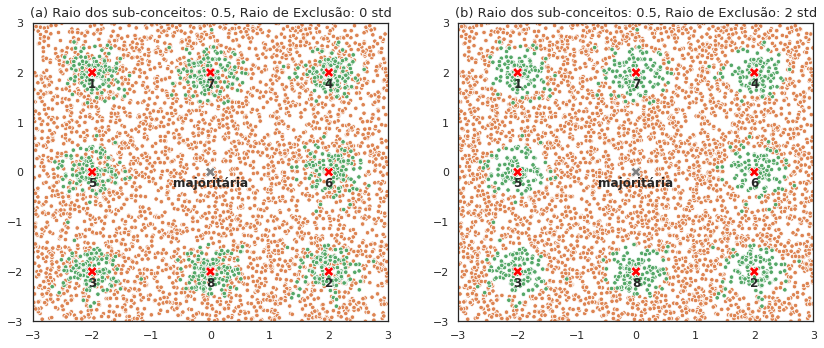

In [46]:
e_figure = [0,2]
X_samples1, Y_samples1, sample_types1, sample_statistics1 = make_binary_classification(number_samples=5000, 
                                                                                    minority_class_centers=grid_values[1::],
                                                                                    minority_class_radius=0.5,
                                                                                    majority_bounds=majority_bounds,
                                                                                    exclusion_radius=e_figure[0], 
                                                                                    number_variables=2, 
                                                                                    majority_class_weight=0.8, 
                                                                                    k=5)

X_samples2, Y_samples2, sample_types2, sample_statistics2 = make_binary_classification(number_samples=5000, 
                                                                                    minority_class_centers=grid_values[1::],
                                                                                    minority_class_radius=0.5,
                                                                                    majority_bounds=majority_bounds,
                                                                                    exclusion_radius=e_figure[1], 
                                                                                    number_variables=2, 
                                                                                    majority_class_weight=0.8, 
                                                                                    k=5)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(x=X_samples1[:,0], 
                y=X_samples1[:,1], 
                hue=Y_samples1,
                s=20, hue_order=[-10, 0,1,2,3,4,5,6,7],
                markers="s", legend=False, ax=ax[0])

sns.scatterplot(x=X_samples2[:,0], 
                y=X_samples2[:,1], 
                hue=Y_samples2,
                s=20, hue_order=[-10, 0,1,2,3,4,5,6,7],
                markers="s", legend=False, ax=ax[1])

#Mark cluster centers
centers = grid_values[1::]

grid_keys = ['majoritária']+list(grid.keys())[1::]
grid_values = list(grid.values())
seed_style = ['majoritária' if i==0 else 'minoritária' for i in range(len(grid))]

sns.scatterplot(x=[x[0] for x in grid_values], 
                y=[x[1] for x in grid_values], 
                hue=seed_style,
                s=100, palette=["grey", "red"],
                style=seed_style,
                markers={"majoritária": "X", "minoritária":"X"}, ax=ax[0])
sns.scatterplot(x=[x[0] for x in grid_values], 
                y=[x[1] for x in grid_values], 
                hue=seed_style,
                s=100, palette=["grey", "red"],
                style=seed_style,
                markers={"majoritária": "X", "minoritária":"X"}, ax=ax[1])
for i in range(len(ax)):
    for j in range(len(grid)):
        ax[i].text(grid_values[j][0], grid_values[j][1]-0.3, grid_keys[j], horizontalalignment='center', fontweight='bold')
    ax[i].set(xlim=(-3,3), ylim=(-3,3))
    ax[i].set_title("({}) Raio dos sub-conceitos: 0.5, Raio de Exclusão: {} std".format(chr(97+i), e_figure[i]), fontdict={'fontsize': 13})
    #ax[i].set_axis_off()
    ax[i].autoscale(False)
    ax[i].get_legend().set_visible(False)

plt.tight_layout()
plt.plot()
plt.savefig("../../images/synthetic_dataset_illustration_varying_exclusion_radius.png")
